In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,LSTM,Embedding,Dropout,Activation,Conv1D,Bidirectional,GlobalMaxPool1D
from tensorflow.keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from bs4 import BeautifulSoup
import re
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,mean_squared_error
from sklearn.ensemble import RandomForestClassifier

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/project2/drugsComTest_raw.tsv
/kaggle/input/project2/drugsComTrain_raw.tsv


In [ ]:
df=pd.read_csv('/kaggle/input/project2/drugsCom_raw.tsv',sep='\t')

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.drop(['Unnamed: 0','date'],axis=1,inplace=True)

In [ ]:
condition_df=df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_df=pd.DataFrame(condition_df).reset_index()

In [ ]:
count_df=df[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df

,condition,review
165,Birth Control,28788
262,Depression,9069
594,Pain,6145
125,Anxiety,5904
80,Acne,5588
...,...,...
60,76</span> users found this comment helpful.,1
61,77</span> users found this comment helpful.,1
62,79</span> users found this comment helpful.,1
64,84</span> users found this comment helpful.,1


In [ ]:
target=count_df[count_df['review']>3000]['condition'].values

In [ ]:
def condition_parser(x):
    if x in target:
        return x
    else:
        return 'OTHER'
df['condition']=df['condition'].apply(lambda x: condition_parser(x))

In [ ]:
df=df[df['condition']!='OTHER']

In [ ]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in words]
    # 7. space join words
    return ' '.join(stemming_words)

# 딥러닝

In [ ]:
df['review_clean']=df['review'].apply(review_to_words)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review_clean'])
sequences = tokenizer.texts_to_sequences(df['review_clean'])

max_sequence_length = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_sequence_length)

label_encoder_condition = LabelEncoder()
label_encoder_drug = LabelEncoder()

y_condition = label_encoder_condition.fit_transform(df['condition'])
y_condition = pd.get_dummies(y_condition).values
x_train,x_test,y_train,y_test=train_test_split(X,y_condition,test_size=0.2,random_state=42)

print(x_train.shape,x_test.shape)

2024-04-11 08:38:30.196502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 08:38:30.196626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 08:38:30.333569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_34/2151439243.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
/tmp/ipykernel_34/3395708583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

(59160, 1099) (14791, 1099)


In [ ]:
len(y_condition[0])

10

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_layer)
lstm_layer = LSTM(64)(embedding_layer)
condition_output = Dense(len(label_encoder_condition.classes_), activation='softmax', name='condition_output')(lstm_layer)
model = Model(inputs=input_layer, outputs=condition_output)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=10, batch_size=128)


Epoch 1/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.4943 - loss: 1.5201 - val_accuracy: 0.6538 - val_loss: 0.8561
Epoch 2/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.6868 - loss: 0.8239 - val_accuracy: 0.7491 - val_loss: 0.6767
Epoch 3/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.7654 - loss: 0.6198 - val_accuracy: 0.7828 - val_loss: 0.5686
Epoch 4/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.7983 - loss: 0.5529 - val_accuracy: 0.7991 - val_loss: 0.5743
Epoch 5/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.8260 - loss: 0.4939 - val_accuracy: 0.8377 - val_loss: 0.4564
Epoch 6/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.8678 - loss: 0.3722 - val_accuracy: 0.8574 - val_loss: 0.3967
Epoch 7/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.8855 - loss: 0.3161 - val_accuracy: 0.8607 - val_loss: 0.3864
Epoch 8/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.8969 - loss: 0.2961 - 

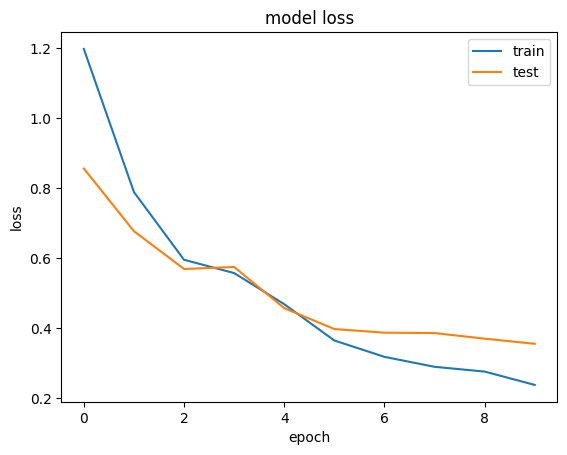

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')
plt.legend(['train','test'])
plt.show()

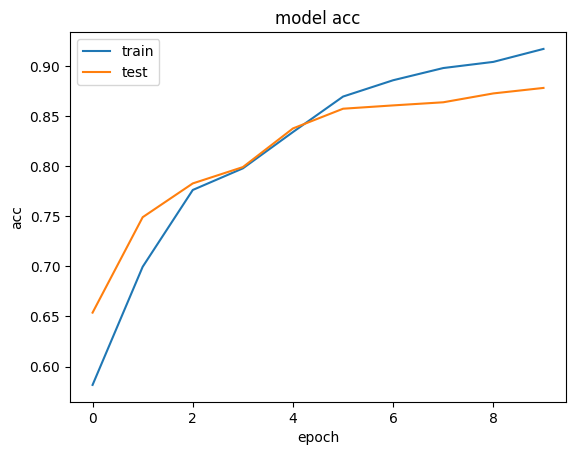

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','test'])
plt.title('model acc')
plt.show()

In [ ]:
new_reviews = "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
new_reviews=list(df['review'][:5])
ans_conditions=list(df['condition'][:5])
for i in range(5):
    new_reviews_cleaned = new_reviews[i].lower().replace('[^a-zA-Z]', ' ')
    new_sequences = tokenizer.texts_to_sequences([new_reviews_cleaned])
    new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
    new_sequences
    pred = model.predict(new_padded_sequences)
    predicted_condition = label_encoder_condition.classes_[np.argmax(pred)]

    print(f'Predicted Condition: {predicted_condition}')
    print(f'Answer Condition: {ans_conditions[i]}')
    drug_ratings = df[df["condition"] == predicted_condition].groupby("drugName")[["rating", "usefulCount"]].mean()
    recommended_drugs_rt = set(drug_ratings.nlargest(5,'rating').index.tolist())
    print("Recommended Drugs based on ratings only:")
    for i, drug in enumerate(recommended_drugs_rt):
        print(i+1, drug)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Condition: ADHD
Answer Condition: ADHD
Recommended Drugs based on ratings only:
1 Pemoline
2 Cylert
3 Desoxyn
4 Selegiline
5 ProCentra
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Condition: Birth Control
Answer Condition: Birth Control
Recommended Drugs based on ratings only:
1 Plan B
2 Heather
3 Elinest
4 Provera
5 Ortho-Novum 7 / 7 / 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Condition: Birth Control
Answer Condition: Birth Control
Recommended Drugs based on ratings only:
1 Plan B
2 Heather
3 Elinest
4 Provera
5 Ortho-Novum 7 / 7 / 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Condition: Bipolar Disorde
Answer Condition: Bipolar Disorde
Recommended Drugs based on ratings only:
1 Eskalith-CR
2 Nuvigil
3 Armodafinil
4 Klonopin Wafer
5 Tiagabine
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Condition: Birth Control
Answer Condition: Birth Control
Recommended Drugs based on ratings only:
1 Plan B
2 Heather
3 Elinest
4 Prove

In [ ]:
new_reviews = "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
new_reviews=list(df['review'][:5])
ans_conditions=list(df['condition'][:5])
# 기존의 예측 코드...
new_reviews_cleaned = new_reviews[i].lower().replace('[^a-zA-Z]', ' ')
new_sequences = tokenizer.texts_to_sequences([new_reviews_cleaned])
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
pred = model.predict(new_padded_sequences)
predicted_condition = label_encoder_condition.classes_[np.argmax(pred)]
predicted_conditions.append(predicted_condition)
actual_conditions.append(ans_conditions[i])

    # 기존 출력 코드...

# 실제 값과 예측 값을 기반으로 정밀도, 재현율, F1 점수 계산
# 여기서 average 매개변수는 라벨이 다중 클래스인 경우 어떻게 평균을 낼지 정하는 것입니다. 'macro', 'micro', 'weighted', 'samples' 중 선택할 수 있습니다.
# 'micro': 글로벌로 TP, FN, FP를 계산하여 정밀도, 재현율, F1 점수를 계산합니다.
# 'macro': 각 라벨에 대해 정밀도, 재현율, F1 점수를 계산하고, 라벨 간 평균을 낸 값입니다. 라벨 크기를 고려하지 않습니다.
# 'weighted': 각 라벨에 대해 정밀도, 재현율, F1 점수를 계산하고, 각 라벨의 샘플 수에 따라 가중 평균을 낸 값입니다.
precision = precision_score(actual_conditions, predicted_conditions, average='macro')
recall = recall_score(actual_conditions, predicted_conditions, average='macro')
f1 = f1_score(actual_conditions, predicted_conditions, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# 머신러닝

In [ ]:
df['review_clean']=df['review'].apply(review_to_words)

/tmp/ipykernel_34/2151439243.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [ ]:
vectorizer=TfidfVectorizer(lowercase=True)
X=vectorizer.fit_transform(df['review_clean'])

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,df['condition'],test_size=0.2,random_state=42)

# Randomforest

In [ ]:
model1=RandomForestClassifier()
model1.fit(x_train,y_train)

RandomForestClassifier()

In [ ]:
pred=model1.predict(x_test)
print(classification_report(pred,y_test))

                 precision    recall  f1-score   support

           ADHD       0.88      0.96      0.92       626
           Acne       0.89      0.98      0.93      1035
        Anxiety       0.76      0.85      0.80      1012
Bipolar Disorde       0.76      0.95      0.85       659
  Birth Control       1.00      0.92      0.95      6271
     Depression       0.86      0.81      0.83      1915
       Insomnia       0.84      0.90      0.87       652
        Obesity       0.72      0.84      0.78       639
           Pain       0.93      0.92      0.92      1283
    Weight Loss       0.75      0.80      0.78       699

       accuracy                           0.90     14791
      macro avg       0.84      0.89      0.86     14791
   weighted avg       0.90      0.90      0.90     14791



In [ ]:
new_review = ["This drug is amazing, it really helped me with my condition!"]
new_review = vectorizer.transform(new_review)
new_condition = model1.predict(new_review)[0]
print("Predicted Condition:", new_condition)

Predicted Condition: Depression


# LightGBM

In [ ]:
import lightgbm as lgb
model3=lgb.LGBMClassifier()
model3.fit(x_train,y_train)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.020537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314606
[LightGBM] [Info] Number of data points in the train set: 59160, number of used features: 3837
[LightGBM] [Info] Start training from score -3.086624
[LightGBM] [Info] Start training from score -2.586668
[LightGBM] [Info] Start training from score -2.517690
[LightGBM] [Info] Start training from score -2.856470
[LightGBM] [Info] Start training from score -0.943795
[LightGBM] [Info] Start training from score -2.095252
[LightGBM] [Info] Start training from score -2.988658
[LightGBM] [Info] Start training from score -3.041030
[LightGBM] [Info] Start training from score -2.497152
[LightGBM] [Info] Start training from score -3.030124


LGBMClassifier()

In [ ]:
pred=model3.predict(x_test)
print(classification_report(pred,y_test))

                 precision    recall  f1-score   support

           ADHD       0.93      0.96      0.94       656
           Acne       0.93      0.96      0.95      1093
        Anxiety       0.78      0.83      0.81      1064
Bipolar Disorde       0.82      0.87      0.85       779
  Birth Control       0.99      0.97      0.98      5845
     Depression       0.87      0.80      0.83      1949
       Insomnia       0.88      0.89      0.88       684
        Obesity       0.75      0.81      0.78       683
           Pain       0.94      0.94      0.94      1276
    Weight Loss       0.80      0.79      0.80       762

       accuracy                           0.91     14791
      macro avg       0.87      0.88      0.87     14791
   weighted avg       0.91      0.91      0.91     14791



In [ ]:
new_review = ["This drug is amazing, it really helped me with my condition!"]
new_review = vectorizer.transform(new_review)
new_condition = model3.predict(new_review)[0]
print("Predicted Condition:", new_condition)

Predicted Condition: Depression
